# Базовое решение Задачи 2 "Спрос на бронирование отелей"

Данные содержат сведения о спросе на отели. Каждое наблюдение представляет собой бронирование отеля. Набор данных учитывает бронирования, которые должны прибыть в период с 1 июля 2015 года по 31 августа 2017 года, включая фактически поступившие и отмененные бронирования.


- Тренировочный набор - **44 634 строк**.


## Считывание данных

In [ ]:
# Загрузка файлов с локального компьютера в облачное хранилище Colab
from google.colab import files
uploaded = files.upload()

In [ ]:
# иморитирование всех необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

In [ ]:
# Считываем тренировочные данные
train = pd.read_csv("train_final.csv")

print(f"Train dataset shape: {train.shape}")

Train dataset shape: (44638, 29)


In [ ]:
# Посмотрим как выглядят данные
train.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,Resort Hotel,0,3,2016,February,7,12,0,2,2,...,E,F,0,No Deposit,0,Transient,81.0,1,0,2016-02-14
1,City Hotel,1,50,2016,November,47,18,1,2,2,...,A,A,0,No Deposit,0,Transient,93.6,0,2,2016-10-09
2,City Hotel,0,14,2015,September,37,7,1,5,2,...,F,F,0,No Deposit,0,Contract,166.0,0,3,2015-09-13
3,City Hotel,0,18,2015,December,50,6,2,0,2,...,A,A,0,No Deposit,0,Transient,107.0,0,0,2015-12-08
4,City Hotel,1,263,2016,September,40,29,2,4,2,...,A,A,0,No Deposit,0,Transient,100.3,0,0,2016-01-18


## Исследование данных

Прежде чем переходить к непосредственному построению модели, в первую очередь необходимо исследовать имеющихся у вас набор данных:
1. Какую задачу вы решаете (классификация, регрессия) и какая переменная является целевой?
2. Сколько переменных в данных и какого они типа?
3. Имеются ли в данных пропуски?

In [ ]:
print("Number of missing values in train dataset:")
print(train.isna().sum())


Number of missing values in train dataset:
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44638 entries, 0 to 44637
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           44638 non-null  object 
 1   is_canceled                     44638 non-null  int64  
 2   lead_time                       44638 non-null  int64  
 3   arrival_date_year               44638 non-null  int64  
 4   arrival_date_month              44638 non-null  object 
 5   arrival_date_week_number        44638 non-null  int64  
 6   arrival_date_day_of_month       44638 non-null  int64  
 7   stays_in_weekend_nights         44638 non-null  int64  
 8   stays_in_week_nights            44638 non-null  int64  
 9   adults                          44638 non-null  int64  
 10  children                        44638 non-null  float64
 11  babies                          44638 non-null  int64  
 12  meal                            

**Проверим баланс классов.**

В задаче классификации данные называются несбалансированными (Imbalanced Data), если в обучающей выборке доли объектов разных классов существенно различаются, также говорят, что «классы не сбалансированы».

In [ ]:
train['is_canceled'].value_counts()

0    31354
1    13284
Name: is_canceled, dtype: int64

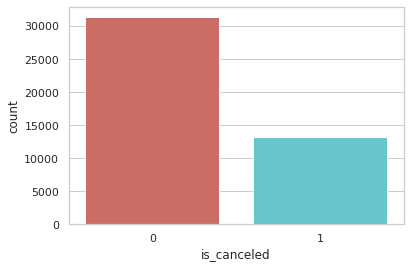

In [ ]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
y_data = pd.DataFrame(train['is_canceled'])
sns.countplot(x='is_canceled', data=y_data, palette='hls')
plt.show()

## Предобработка данных

Исходя из анализа данных, можно сделать выводы:
- в данных пропусков нет
- в данных имеются категориальные признаки
- в задаче решается задача бинарной классификации

### Кодирование признаков

**Категориальные признаки называют по-разному: факторными, номинальными.**

Их значения определяют факт принадлежности к какой-то категории. Примеры таких признаков: пол, страна проживания, номер группы, категория товаров и т.п. Ясно, что для компьютерной обработки вместо «понятного для человека» значения (в случае страны — ‘Russia’, ‘GB’, ‘France’ и т.п.) хранят числа. 

**Категориальные** признаки называют по-разному: **факторными**, **номинальными**. Их значения определяют факт принадлежности к какой-то категории. 

Примеры таких признаков: пол, страна проживания, номер группы, категория товаров и т.п. Ясно, что для компьютерной обработки вместо «понятного для человека» значения (в случае страны — ‘Russia’, ‘GB’, ‘France’ и т.п.) хранят числа. 

Существуют разные способы кодирования категориальных признаков:
1. Простейший кодировщий `sklearn.preprocessing.LabelEncoder`, который каждой категории сопоставляет некоторое целое число (собственно, номер категории).

Например, существует категориальная переменная:

```markdown
   |  Статус вакцинации |
---|--------------------|
1  |    Вакцинирован    |
2  |  Не вакцинирован   |
3  |     Мед отвод      |
4  |     Мед отвод      |
5  |  Не вакцинирован   |
6  |    Вакцинирован    |

```

После применения кодирования с помощью LabelEncoder получаем следущее (собственно он закодировал наши категориальные переменные: Вакцинирован = 0, Не вакцинирован = 1, Мед отвод = 2):

```markdown
   |  Статус вакцинации |
---|--------------------|
1  |         0          |
2  |         1          |
3  |         2          |
4  |         2          |
5  |         1          |
6  |         0          |

```

2. Метод библиотеки Pandas:

`pandas.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)[source]`

Например, существует категориальная переменная:

```markdown
   |  Статус вакцинации |
---|--------------------|
1  |    Вакцинирован    |
2  |  Не вакцинирован   |
3  |     Мед отвод      |
4  |     Мед отвод      |
5  |  Не вакцинирован   |
6  |    Вакцинирован    |

```

Метод принимает категориальную переменную в качестве аргумента. Далее создает новую переменную для каждой категории, так что каждая фиктивная переменная содержит данные 1 или 0. 1 - указывает на наличие определенной категории и 0 - указывает на отсутствие этой категории.

```markdown
   | Статус вакцинации | Вакцинирован | Не вакцинирован | Мед отвод |
---|-------------------|--------------|-----------------|-----------|
1  |   Вакцинирован    |      1       |        0        |     0     |
2  | Не вакцинирован   |      0       |        1        |     0     |
3  |    Мед отвод      |      0       |        0        |     1     |
4  |    Мед отвод      |      0       |        0        |     1     |
5  | Не вакцинирован   |      0       |        1        |     0     |
6  |   Вакцинирован    |      1       |        0        |     0     |

```

3. Кодировщик библиотеки Sklearn `from sklearn.preprocessing import OneHotEncoder`.

По принципу работы действует точно также как get_dummies().

Основное отличие - это кодировщик, т.е. это некоторая модель которая обучилась на данных, запомнила словарь и т.д., дальше может быть с этими параметры применяться к другому набору данных, к новым данным например.

Get_dummies() - это просто метод класса, который по сути вы одноразово используете.

In [ ]:
# Выбрем признаки, которые являются категориальными (строковыми)
train.loc[:, train.dtypes == object]

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status_date
0,Resort Hotel,February,BB,PRT,Direct,Direct,E,F,No Deposit,Transient,2016-02-14
1,City Hotel,November,BB,BEL,Online TA,TA/TO,A,A,No Deposit,Transient,2016-10-09
2,City Hotel,September,BB,ITA,Online TA,TA/TO,F,F,No Deposit,Contract,2015-09-13
3,City Hotel,December,BB,ESP,Online TA,TA/TO,A,A,No Deposit,Transient,2015-12-08
4,City Hotel,September,BB,DEU,Online TA,TA/TO,A,A,No Deposit,Transient,2016-01-18
...,...,...,...,...,...,...,...,...,...,...,...
44633,City Hotel,June,BB,JPN,Online TA,TA/TO,D,D,No Deposit,Transient,2017-06-28
44634,Resort Hotel,September,BB,GBR,Online TA,TA/TO,E,F,No Deposit,Transient,2015-10-03
44635,City Hotel,April,SC,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,2017-02-09
44636,City Hotel,September,HB,NOR,Offline TA/TO,TA/TO,A,A,No Deposit,Transient-Party,2016-09-12


In [ ]:
train = train.drop(columns=['reservation_status_date', 'country', 'assigned_room_type', 'reserved_room_type'])


In [ ]:
cat_features = train.loc[:, train.dtypes == object].columns
cat_features

Index(['hotel', 'arrival_date_month', 'meal', 'market_segment',
       'distribution_channel', 'deposit_type', 'customer_type'],
      dtype='object')

In [ ]:
train['hotel'].value_counts()

City Hotel      29335
Resort Hotel    15303
Name: hotel, dtype: int64

In [ ]:
train['market_segment'].value_counts()

Online TA        21325
Offline TA/TO     9085
Groups            6868
Direct            4922
Corporate         2046
Complementary      308
Aviation            84
Name: market_segment, dtype: int64

In [ ]:
train['deposit_type'].value_counts()

No Deposit    40235
Non Refund     4339
Refundable       64
Name: deposit_type, dtype: int64

In [ ]:
# Закодируем часть категориальных признаков с помощью LabelEncoder()
# а часть с помощью GetDummies()

from sklearn import preprocessing

# 1. Создадим модель кодировщика
label_encoder = preprocessing.LabelEncoder() 

# 2. Обучение кодировщика: по сути тут создает словарь уникальных слов из переданного массива, 
# соотносит для каждого слова число
label_encoder.fit(train['arrival_date_month']) 

# на этом этапе по сути применяет полученный словарь в переданным данных (в данном случае мы передали столбец число)
train['arrival_date_month'] = label_encoder.transform(train['arrival_date_month']) 


train.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,3,2016,3,7,12,0,2,2,...,0,0,0,0,No Deposit,0,Transient,81.0,1,0
1,City Hotel,1,50,2016,9,47,18,1,2,2,...,0,0,0,0,No Deposit,0,Transient,93.6,0,2
2,City Hotel,0,14,2015,11,37,7,1,5,2,...,0,0,0,0,No Deposit,0,Contract,166.0,0,3
3,City Hotel,0,18,2015,2,50,6,2,0,2,...,0,0,0,0,No Deposit,0,Transient,107.0,0,0
4,City Hotel,1,263,2016,11,40,29,2,4,2,...,0,0,0,0,No Deposit,0,Transient,100.3,0,0


In [ ]:
label_encoder.classes_

array(['April', 'August', 'December', 'February', 'January', 'July',
       'June', 'March', 'May', 'November', 'October', 'September'],
      dtype=object)

In [ ]:
categ = ['market_segment', 'customer_type', 'meal', 'distribution_channel']

# Encode Categorical Columns

for col in categ:

    # создание и обучение
    le = preprocessing.LabelEncoder()
    train[col] = le.fit_transform(train[col])

    

train.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,3,2016,3,7,12,0,2,2,...,0,0,0,0,No Deposit,0,2,81.0,1,0
1,City Hotel,1,50,2016,9,47,18,1,2,2,...,0,0,0,0,No Deposit,0,2,93.6,0,2
2,City Hotel,0,14,2015,11,37,7,1,5,2,...,0,0,0,0,No Deposit,0,0,166.0,0,3
3,City Hotel,0,18,2015,2,50,6,2,0,2,...,0,0,0,0,No Deposit,0,2,107.0,0,0
4,City Hotel,1,263,2016,11,40,29,2,4,2,...,0,0,0,0,No Deposit,0,2,100.3,0,0


In [ ]:
# Попробуем другой вариант кодировщика
train = pd.get_dummies(train, columns=['hotel', 'market_segment', 'deposit_type'])

train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,market_segment_0,market_segment_1,market_segment_2,market_segment_3,market_segment_4,market_segment_5,market_segment_6,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable
0,0,3,2016,3,7,12,0,2,2,0.0,...,0,0,0,1,0,0,0,1,0,0
1,1,50,2016,9,47,18,1,2,2,0.0,...,0,0,0,0,0,0,1,1,0,0
2,0,14,2015,11,37,7,1,5,2,2.0,...,0,0,0,0,0,0,1,1,0,0
3,0,18,2015,2,50,6,2,0,2,0.0,...,0,0,0,0,0,0,1,1,0,0
4,1,263,2016,11,40,29,2,4,2,0.0,...,0,0,0,0,0,0,1,1,0,0


In [ ]:
train.dtypes

is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                  int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                                int64
distribution_channel                int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
booking_changes                     int64
days_in_waiting_list                int64
customer_type                       int64
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
hotel_City Hotel                    uint8
hotel_Resort Hotel                

## Обучение модели

Теперь наши данные готовы для обучения модели.

In [ ]:
# Выделим вектор признаков и вектор ответов
X = train.drop(columns=['is_canceled'])
y = train['is_canceled']

Всего у нас получилось 33 признака.

In [ ]:
print(f'X shape: {X.shape}')
print(f'Y shape: {y.shape}')

X shape: (44638, 33)
Y shape: (44638,)


In [ ]:
# Создадим модель логистической регрессии
model = LogisticRegression()

# обучение модели
model.fit(X, y)

# предсказание ответов для тестовой выборки
answers_pred = model.predict(X)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# answers_pred - ответы которые вернула модель для X_test
# y_test - это правильные ответы для X_test
print(f'Accuracy: {accuracy_score(y, answers_pred)}')
print(f'Precision: {precision_score(y, answers_pred)}')
print(f'Recall: {recall_score(y, answers_pred)}')

Accuracy: 0.8029257583225055
Precision: 0.7877388739258689
Recall: 0.4623607347184583


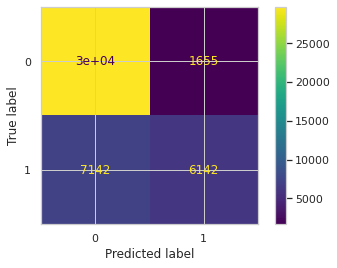

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y, answers_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

